# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_10Cases_H2_Iter_LOG/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_10Cases_H2_Iter_LOG/DeepONet/Run_1/')

FigDir           = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


# DataType         = 'train'
# CasesVec         = range(0,5000,500)#100,10)
DataType         = 'test'
CasesVec         = range(10) #[1,0,2]



NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/0DReact_Isobaric_10Cases_H2_Iter_LOG/DeepONet/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x160505d60>, <keras.layers.core.dense.Dense object at 0x160533fd0>, <keras.layers.core.dense.Dense object at 0x16052b340>, <keras.layers.core.dense.Dense object at 0x16052be20>])
[ROMNet - component.py              ]:       Constructing Component: Branch_2
[ROMNet - sub_component.py          ]:         Constructed Sub-Component

## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
FileName     = DataDir + '/Orig/train/ext/y.csv.1'
Data         = pd.read_csv(FileName, header=0)
VarNames     = list(Data.columns)
VarNames.remove('t')

FileName     = DataDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)


FileName     = DataDir + '/Orig/'+DataType+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

### Loading Variables Info

In [6]:
Vars  = VarNamesAnti

Vars0 = []
for Var in Vars:
    Vars0.append(str(Var)+'0')
    
InputVars = Vars0+['t']

### Loading and Plotting Test/Training Data

In [ ]:
VarOI      = 'H2'
VarOI_Name = 'H2'


iVar     = Vars.index(VarOI)


ax   = []
fig  = []
fig1 = plt.figure()
fig.append(fig1)
ax.append(plt.axes())

MSE   = 0.

jTest = 0
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
    tVec0        = Data.to_numpy()[0,0]
    tVec         = Data.to_numpy()[:,0] - tVec0
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[Vars].to_numpy()
    print('T = ', Data['T'].to_numpy()[0], 'K')
    
    DFa = Data.iloc[range(1,len(Data))]['t'].reset_index(drop=True) - Data.iloc[range(0,len(Data)-1)]['t'].reset_index(drop=True)
    DFb = Data.iloc[range(0,len(Data)-1)][Vars].reset_index(drop=True)
    DFc = Data.iloc[range(1,len(Data))][Vars].reset_index(drop=True)
    DataAll         = pd.concat( [DFa, DFb, DFc], axis=1, ignore_index=True )
    DataAll.columns = ['t'] + Vars0 + Vars
        
    if (jTest == 0):
        Label1 = 'ODE'
        Label2 = 'PCA'
        Label3 = 'DeepONet'
        #Label3 = 'flexDeepONet'
    else:
        Label1 = ''
        Label2 = ''
        Label3 = ''

    ax[0].plot(tVec+tVec0, y_Data[:,iVar],  '-', c=ColorVec[0], label=Label1)

    
    DataAll_        = DataAll.copy()
    
    DataAll_[Vars0] = np.log10( DataAll_[Vars0].to_numpy() + 1.e-14 )# * (1. + np.random.normal(0., 5.e-2, (len(DataAll_),1)))
    y_Pred          = 10.**( model.predict(DataAll_[InputVars]) ) 
    
    #DataAll_[Vars0] = DataAll_[Vars0].to_numpy()*(1.)#+np.random.normal(0., 5.e-2, (len(DataAll_),1)))
    #y_Pred          = model.predict(DataAll_[InputVars])
    
    yPredDF         = pd.DataFrame(y_Pred, columns=Vars)
    yPredDF['t']    = tVec[1::]
    
    
    iStart       = 0
    y_Pred       = np.log10( DataAll[Vars0].iloc[iStart:iStart+1].to_numpy() + 1.e-14 )
    #y_Pred       = DataAll[Vars0].iloc[iStart:iStart+1].to_numpy()
    yPredDF      = pd.DataFrame(y_Pred, columns=Vars)
    t            = Data['t'].iloc[iStart]
    yPredDF['t'] = t
    j            = 0
    for i in range(iStart,200): #len(DataAll)):
        Deltat         = DataAll['t'].iloc[i]
        
        #DataStart      = DataAll[Vars0].iloc[i:i+1]
        DataStart      = pd.DataFrame(y_Pred, columns=Vars0)
        DataStart['t'] = Deltat

        y_Pred         = model.predict(DataStart[InputVars])
        t             += Deltat 
        
        yPredDF_       = pd.DataFrame(10.**(y_Pred), columns=Vars)
        #yPredDF_       = pd.DataFrame(y_Pred, columns=Vars)
        yPredDF_['t']  = t
        yPredDF        = pd.concat([yPredDF, yPredDF_], axis=0)
        
        j += 1
    
    yPredDF.reset_index(drop=True, inplace=True)
    
    
    
    ax[0].plot(yPredDF['t'].to_numpy()[1:], yPredDF[VarOI].to_numpy()[1:], 'o:', c=ColorVec[1], label=Label3)
     
    jTest += 1
    

ax[0].set_xscale('log')
ax[0].set_xlabel('Time [s]')
if (VarOI == 'T'):
    ax[0].set_ylabel('Temperature [K]')
else:
    ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
#ax[0].set_xlim([1.e-8,1.e-2])
ax[0].legend()
    
    
# MSE_ = MSE.sum(axis=0) / len(CasesVec) / (MSE.shape[0])
# print('Mean Squared Error = ', MSE_)
    

if (FigDir):
    fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

T =  993.0 K
T =  1009.0 K
T =  997.0 K
T =  1007.0 K
T =  1001.0 K
T =  995.0 K
T =  991.0 K


## Plotting Loss Histories

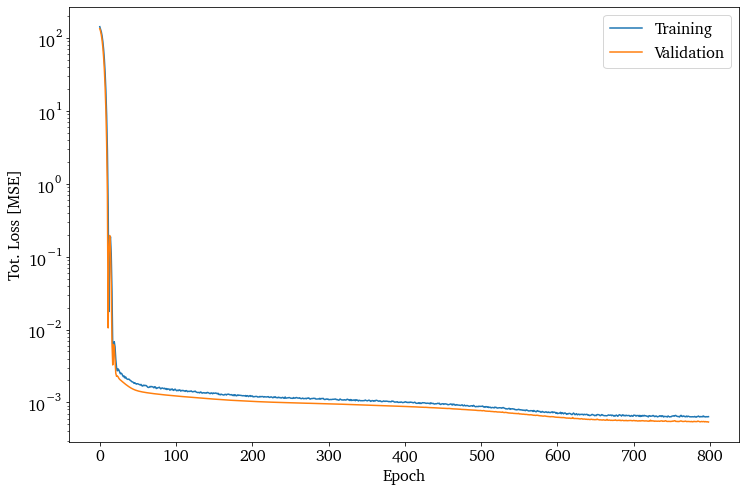

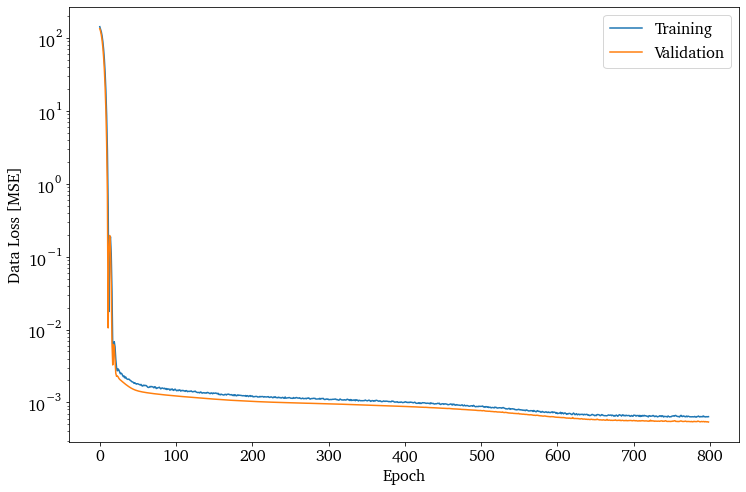

In [8]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk's Outputs

Text(0, 0.5, '$\\phi_{2_{i}}$')

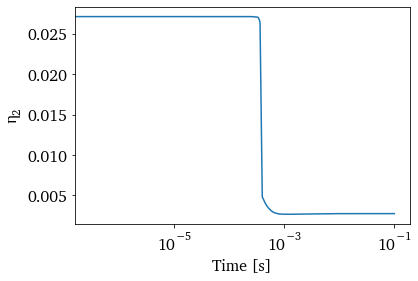

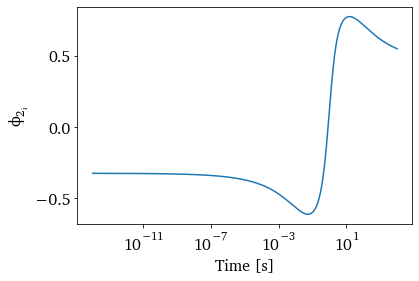

In [9]:
iTrunk           = 1
iTest            = 0


FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

fig = plt.figure()
plt.plot(Data['t'], Data[Vars[iTrunk]])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,1,1)

tVecTot = np.logspace(-14,4,1000)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [10]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)
n_ics         = 500

Cols   = []
NewFlg = True
for iC in range(n_ics):

    try:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iC+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

        DataICTemp       = Data[Vars].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))
            
    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

DataIC.head()

,T,H2,H,O,O2,OH,H2O,HO2,H2O2,N,NH,NH2,NH3,NNH,NO,NO2,N2O,HNO,N2
0,993.0,0.027148,0.0,0.0,0.216095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756757
1,1009.0,0.027254,0.0,0.0,0.216071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756675
2,997.0,0.027466,0.0,0.0,0.216024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756510
3,1007.0,0.027360,0.0,0.0,0.216048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756592
4,1001.0,0.026989,0.0,0.0,0.216130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756881


In [11]:
n_ics         = 500

Cols   = []
NewFlg = True

FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.1'
DataAll          = pd.read_csv(FileName, header=0)[Vars]

DataBranch       = model.net.layers_dict['DeepONet']['Branch']['DeepONet-Branch_Normalization'](DataAll.to_numpy())

Text(0.5, 0, '$\\alpha_{1_D}$')

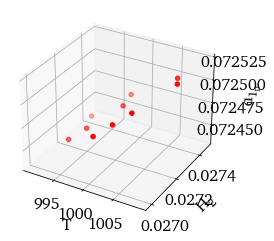

In [12]:
iBranch = 0
iVar    = 0



output_branch = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['T'], DataIC['H2'], output_branch[:,iVar], c='r')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$H_2$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Block + Trunk's Outputs

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


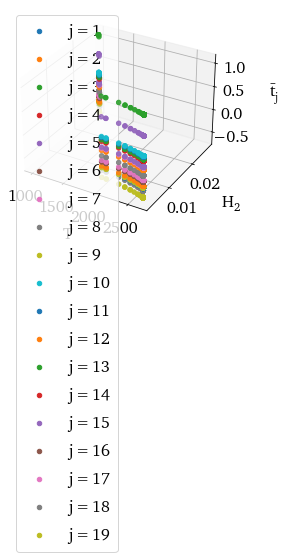

In [13]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
                                   
output_stretch = model.net.system_of_components['DeepONet'].components['Stretch'].call(DataBranch, model.net.layers_dict, None, training=False)
#output_ = np.log(1. + np.exp(output_))

for iBranch in range(len(Vars)):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataAll['T'], DataAll['H2'], output_stretch[:,iBranch], label=r'$j='+str(iBranch+1)+'$')
    
    DF = pd.DataFrame(np.concatenate([DataAll['T'].to_numpy()[...,np.newaxis], DataAll['H2'].to_numpy()[...,np.newaxis], output_stretch[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    #DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iVar]+'.csv', index=False)

ax.set_xlabel('\n'+r'$T$', rotation = 0)
ax.set_ylabel(r'           $H_2$', rotation = 0)
ax.set_zlabel(r'         $\bar{t}_j$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput.eps', format='eps', bbox_inches='tight')

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


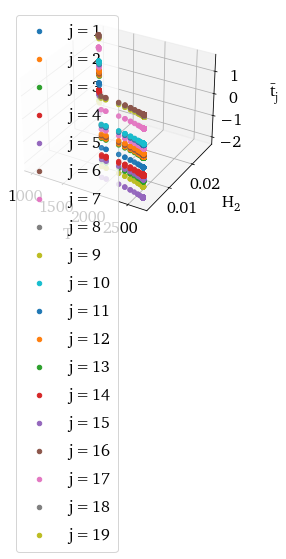

In [14]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_shift = model.net.system_of_components['DeepONet'].components['Shift'].call(DataBranch, model.net.layers_dict, None, training=False)
#output_ = np.log(1. + np.exp(output_))

for iBranch in range(len(Vars)):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataAll['T'], DataAll['H2'], output_shift[:,iBranch], label=r'$j='+str(iBranch+1)+'$')
    
    DF = pd.DataFrame(np.concatenate([DataAll['T'].to_numpy()[...,np.newaxis], DataAll['H2'].to_numpy()[...,np.newaxis], output_shift[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    #DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iVar]+'.csv', index=False)

ax.set_xlabel('\n'+r'$T$', rotation = 0)
ax.set_ylabel(r'           $H_2$', rotation = 0)
ax.set_zlabel(r'         $\bar{t}_j$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [15]:
# for iBranch in range(len(Vars)):

#     DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
#     DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iBranch]+'.csv', index=False)

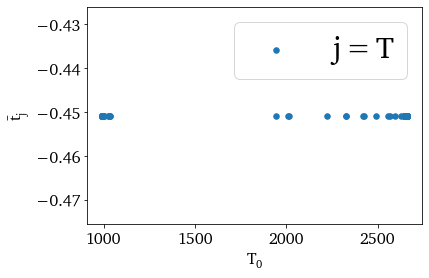

In [16]:
VarNames=['T',
 'H_{2}',
 'H',
 'O',
 'O_{2}',
 'OH',
 'H_{2}O',
 'HO_{2}',
 'H_{2}O_{2}',
 'N',
 'NH',
 'NH_{2}',
 'NH_{3}',
 'NNH',
 'NO',
 'NO_{2}',
 'N_{2}O',
 'HNO',
 'N_{2}']


fig = plt.figure()

for iBranch in [0]:#,1,2,3,5,9,12]:
    plt.scatter(DataAll['T'], output_stretch[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$T_0$')
plt.ylabel(r'$\bar{t}_j$')
#plt.yscale('log')
#plt.xlim([1000,2000])
#plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    
## np.exp(np.log(1.e-6) - np.log(40))

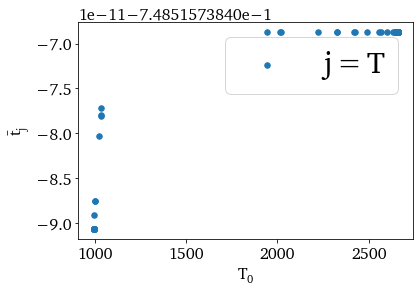

In [17]:
VarNames=['T',
 'H_{2}',
 'H',
 'O',
 'O_{2}',
 'OH',
 'H_{2}O',
 'HO_{2}',
 'H_{2}O_{2}',
 'N',
 'NH',
 'NH_{2}',
 'NH_{3}',
 'NNH',
 'NO',
 'NO_{2}',
 'N_{2}O',
 'HNO',
 'N_{2}']


fig = plt.figure()

for iBranch in [0]:#,1,2,3,5,9,12]:
    plt.scatter(DataAll['T'], output_shift[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$T_0$')
plt.ylabel(r'$\bar{t}_j$')
#plt.yscale('log')
#plt.xlim([1000,2000])
#plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    
## np.exp(np.log(1.e-6) - np.log(40))

In [18]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

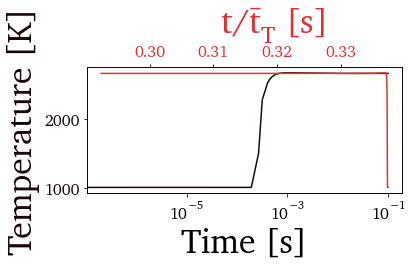

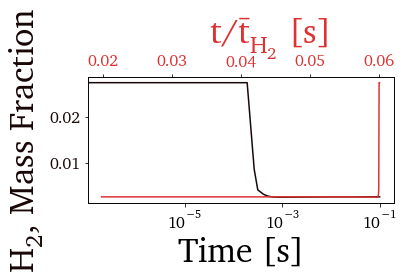

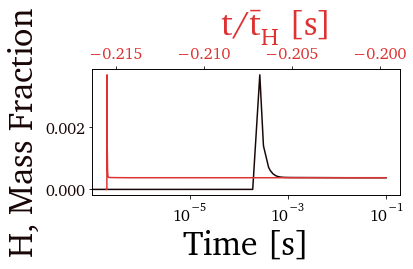

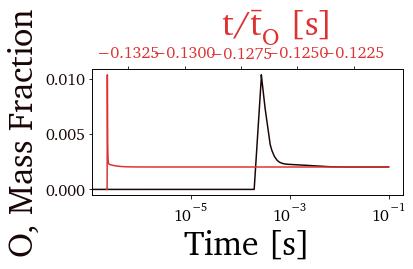

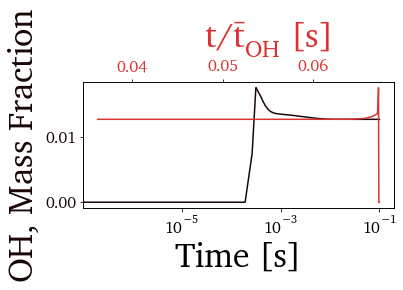

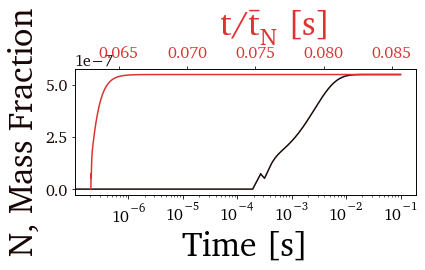

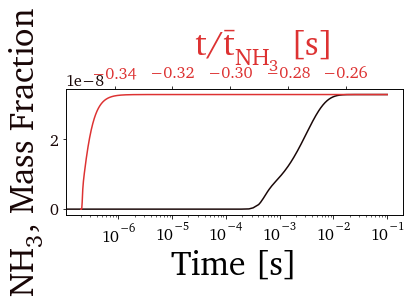

In [19]:
iVarVec   = [0,1,2,3,5,9,12]

for iVar in iVarVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iTest in [1]:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]
        
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'ODE'
            Label2 = 'Rigid Block Prepr.'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

    
        ax1.plot(tVec, yPCA_Data[:,iVar], color=ColorVec[0], label=Label1)

        ax2.plot((tVec+output_shift[iTest,iVar])*output_stretch[iTest,iVar], yPCA_Data[:,iVar], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'Time [s]', size=34)
    if (Vars[iVar] == 'T'):
        ax1.set_ylabel(r'Temperature [K]', color=color, size=34)
    else:
        ax1.set_ylabel(r'$'+VarNames[iVar]+'$, Mass Fraction', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')

    color = ColorVec[1]
    ax2.set_xlabel(r'      $t/\bar{t}_{'+VarNames[iVar]+'}$ [s]', color=color, size=34, labelpad=10)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)
    #ax2.set_xscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_'+Vars[iVar]+'_Shift.eps', format='eps', bbox_inches='tight')

In [20]:
### Experimenting

# n_clusters = 5

# from sklearn.cluster import KMeans
# X = output_.T
# kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
# kmeans.labels_

# for i_cluster in range(n_clusters):
#     print('Cluster '+str(i_cluster+1)+': ', np.array(Vars)[kmeans.labels_==i_cluster])